# Transform and Analyze Survey Data

MyDataHelps export files and export database tables use an efficient, normalized file/table structure to provide the data values collected from participants as they answer surveys. The first three tables shown below show survey data in this "Current Data Format".

It may be useful to transform the survey data from these three tables into a single, flattened table. An example transformation is shown below in the table labeled "Cleaned Data Format".

The sql query below constructs the "Cleaned Data Format". 

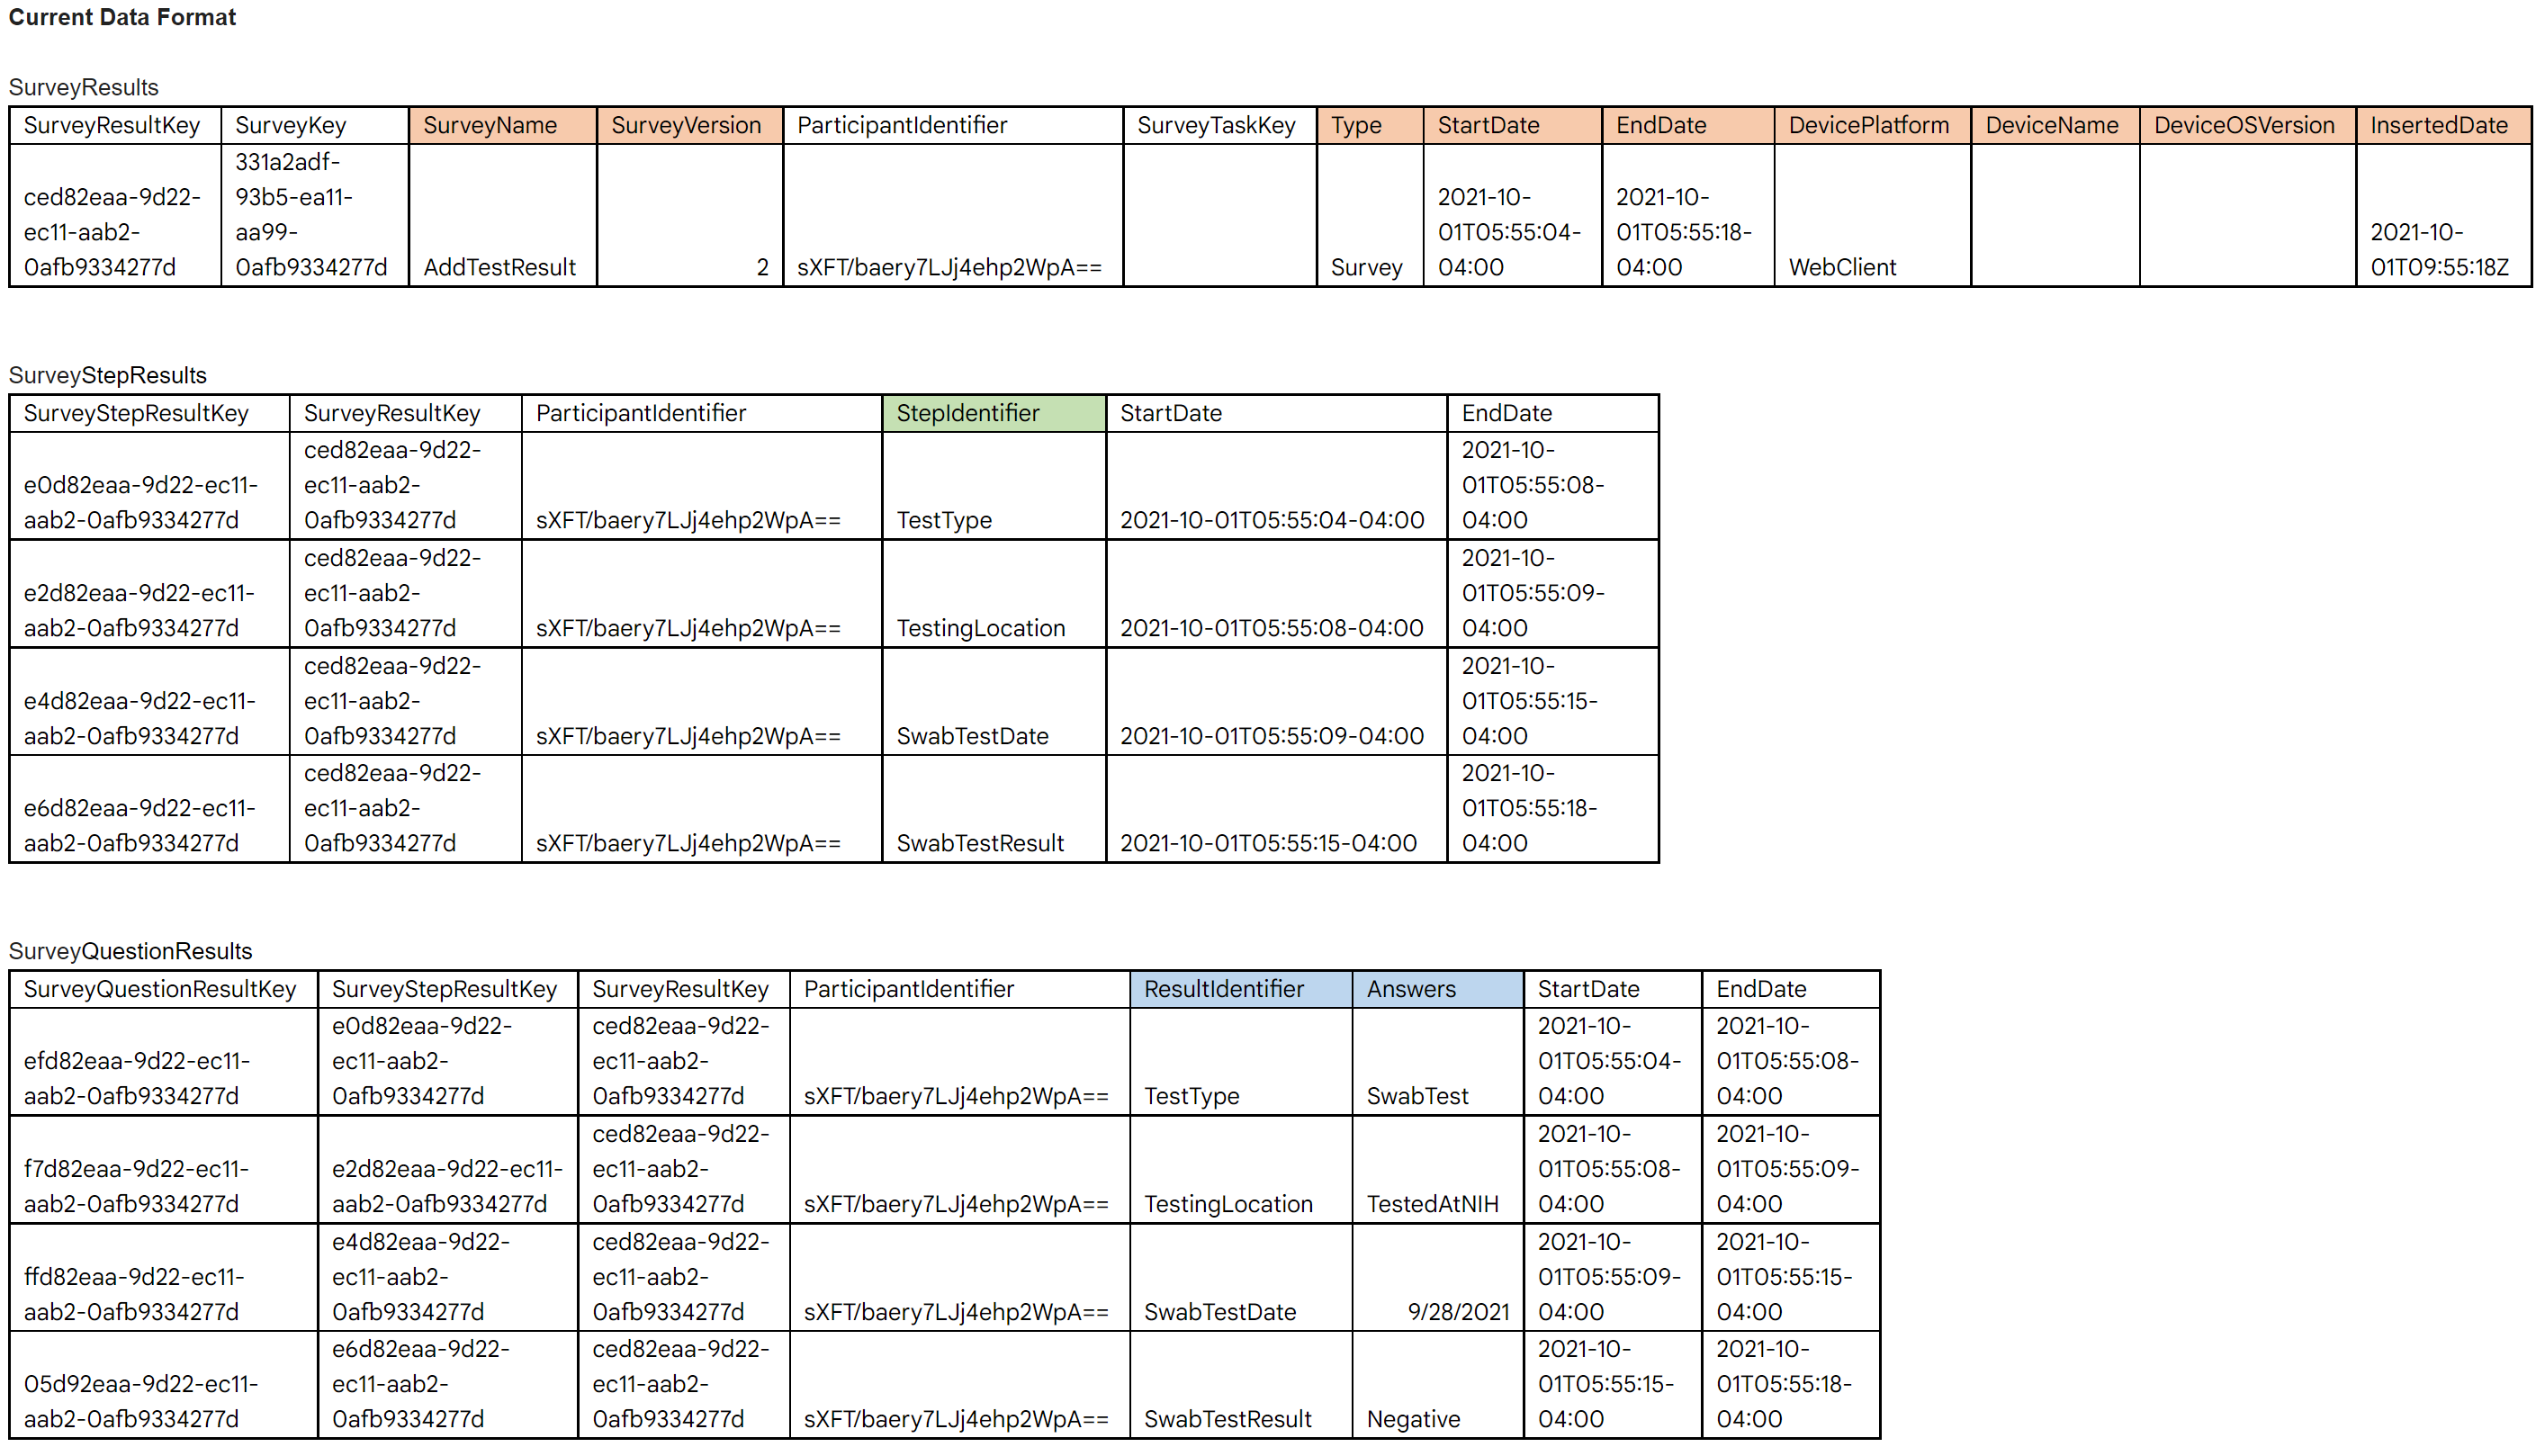

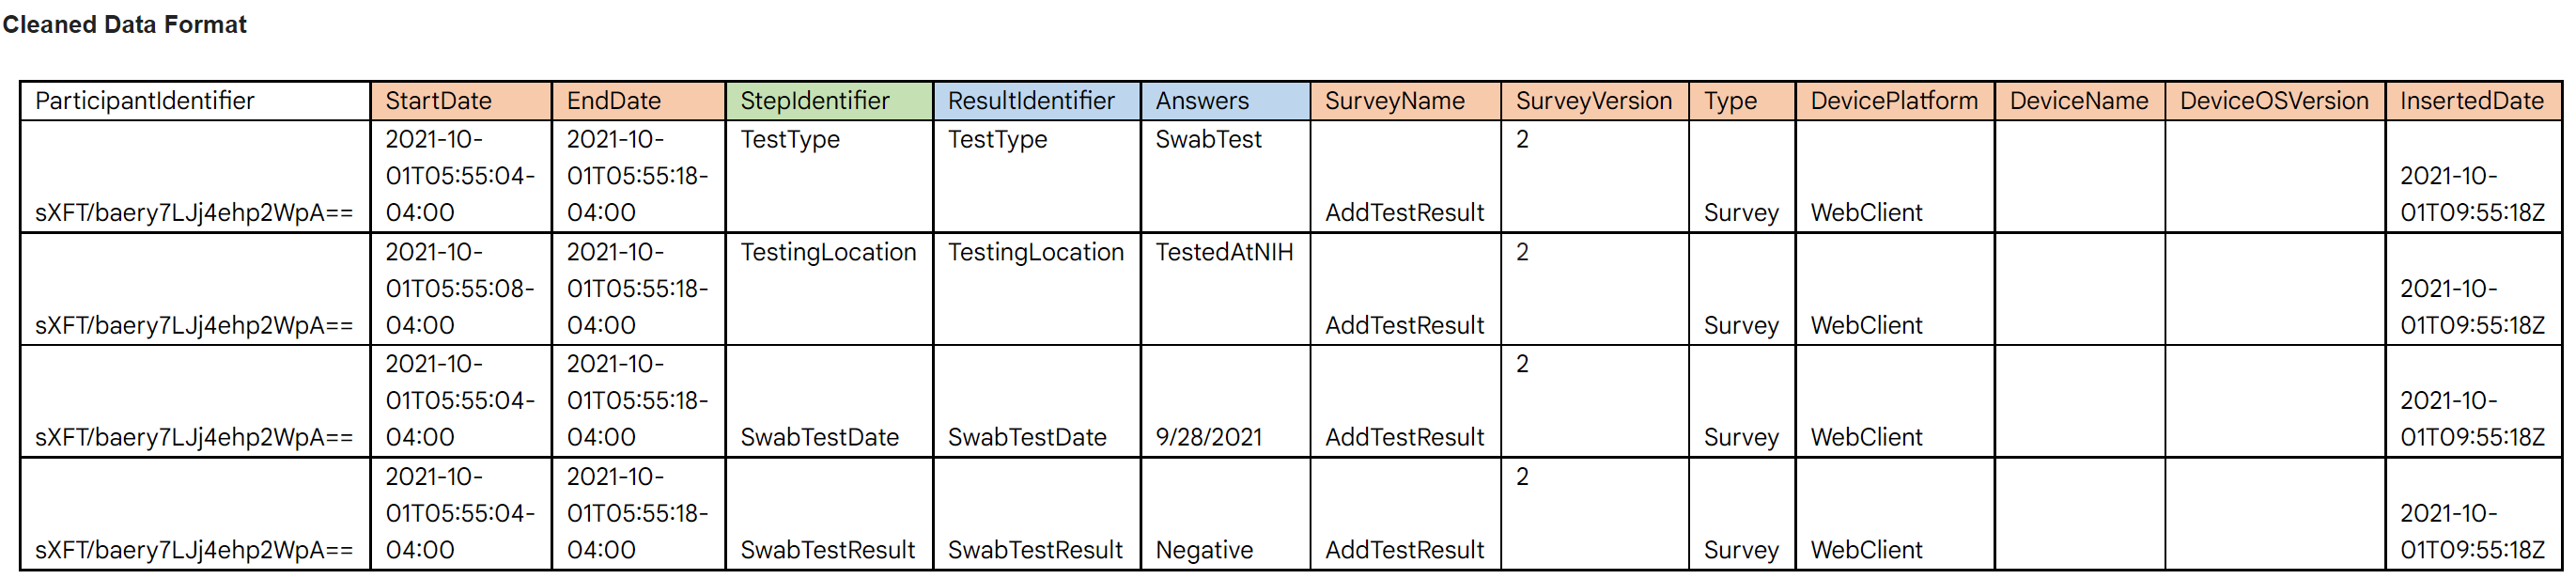

In [1]:
from IPython.display import Image, display 
display(Image(filename='images/current_export_format.png', embed=True))
display(Image(filename='images/cleaned_data_format.png', embed=True))

### Gather Your Export Database Configuration Settings and Credentials

To obtain the configuration settings for your project's Export Database, open MyDataHelps Designer and navigate to the `Settings` tab for your project. Click `Export Explorer`. The `External Applications` tab will provide the required configuration settings. 

In [1]:
import os, sys; sys.path.append("..") 
from src.mdh_query import MDHQuery

import pandas as pd

mdh_query = MDHQuery(
    project_schema_name = "",
    athena_workgroup = "mdh_export_database_external_prod",
    athena_output_bucket_location = "s3://pep-mdh-export-database-qa/execution/",
    aws_profile_name = "" 
)

In [4]:
query_string = f"""
select 
    sr.participantidentifier, 
    sr.startdate,
    sr.enddate,
    ssr.stepidentifier,
    sqr.resultidentifier,
    sqr.answers,
    sr.surveyname,
    sr.type,
    sr.deviceplatform,
    sr.devicename,
    sr.deviceosversion,
    sr.inserteddate
from
    surveyresults sr
    join surveystepresults ssr on ssr.surveyresultkey = sr.surveyresultkey
    join surveyquestionresults sqr on sqr.surveystepresultkey = ssr.surveystepresultkey
    
"""

survey_results = mdh_query.get_query_result(query_string)
survey_results.head(5)

10:12:14 query status: QUEUED
10:12:19 query status: SUCCEEDED
10:12:20 rows: 1593 columns: ['participantidentifier', 'startdate', 'enddate', 'stepidentifier', 'resultidentifier', 'answers', 'surveyname', 'type', 'deviceplatform', 'devicename', 'deviceosversion', 'inserteddate']


,participantidentifier,startdate,enddate,stepidentifier,resultidentifier,answers,surveyname,type,deviceplatform,devicename,deviceosversion,inserteddate
0,1dea8379-49d6-4d02-a5cc-961e838cab9a,2022-09-02 17:32:33.000,2022-09-02 17:32:59.000,Eligibility,IS_OVER_18,[['True']],Standard Consent,Consent,iOS,"iPhone14,3",15.6.1,2022-09-02 17:33:00.000
1,1dea8379-49d6-4d02-a5cc-961e838cab9a,2022-09-02 17:32:33.000,2022-09-02 17:32:59.000,Eligibility,LIVES_IN_AMERICA,[['True']],Standard Consent,Consent,iOS,"iPhone14,3",15.6.1,2022-09-02 17:33:00.000
2,bb607e64-b0ef-4064-a9ae-3143e520c41a,2022-09-06 13:19:39.000,2022-09-06 13:20:08.000,Eligibility,LIVES_IN_AMERICA,[['True']],Standard Consent,Consent,iOS,"iPhone14,3",15.6.1,2022-09-06 13:20:08.000
3,bb607e64-b0ef-4064-a9ae-3143e520c41a,2022-09-06 13:19:39.000,2022-09-06 13:20:08.000,Eligibility,IS_OVER_18,[['True']],Standard Consent,Consent,iOS,"iPhone14,3",15.6.1,2022-09-06 13:20:08.000
4,30a0b083-667e-4de8-97da-45650913db38,2022-09-07 12:41:27.000,2022-09-07 12:41:50.000,Eligibility,LIVES_IN_AMERICA,[['True']],Standard Consent,Consent,iOS,"iPhone14,3",15.6.1,2022-09-07 12:41:51.000


Write the transformed survey results to a local file.

In [5]:
survey_results.to_csv(f"survey_results.csv", index=False)

### Analyze Survey Results

The example below uses the transformed survey result format to answer the questions:
* How many participants generated data for each survey?
* How many data instances of survey data have been generated for each survey?

In [6]:
(
    survey_results[survey_results.type.eq("Survey")].
        groupby(["surveyname"]).
        agg(
            participants=pd.NamedAgg(column="participantidentifier", aggfunc="nunique"),
            results=pd.NamedAgg(column="participantidentifier", aggfunc="count")
        )
)

,participants,results
surveyname,,
Allow Survey Completion via Link,2,14
Baseline (Aussie),6,77
Daily Illness Report,5,11
Date Test,1,1
FamilyHistory (AOU test),1,1
Feedback,39,45
Feeling Sick2,3,30
Feeling Sick?,15,165
Finish Steps cleared when navigating,2,5


The example below uses the transformed survey result format to answer the questions:
* For a specified survey, what answers were provided for each question?
* How many participants provided each answer?

In [7]:
survey_name = "Feeling Sick?"

In [8]:
survey_results["answers_list"] = survey_results.answers.str.replace("[", "", regex=False).str.replace("]", "", regex=False).str.replace("', '", "'|''", regex=False).str.split("|")
(
    survey_results[survey_results.surveyname.eq(survey_name)].
        explode("answers_list").
        groupby(["resultidentifier", "answers_list"]).
        agg(
            participants=pd.NamedAgg(column="participantidentifier", aggfunc="nunique")
        )
).head(10)

participants
resultidentifier                   answers_list                         
COVID19TestResults                 Negative                            4
FluTestResults                     Negative                            1
HouseholdDiagnoses                 'False'                             1
                                   False                              13
                                   True                                2
HouseholdTestedForCovid19          'False'                             1
                                   False                              14
HouseholdTestedForFlu              'False'                             1
                                   False                              13
HouseholdTravelAreaCOVIDWidespread 'VisitedWidespreadArea'             1

### Transform to Matrix

Some analysis patterns prefer data represented in a matrix format. In the following example, a matrix is constructed for a specified survey with structure:
* Each row represents a unique participant
* Each column represents a unique survey question + answer combination
* Each cell is True/False. True = the participant for a given row provided the answer specified for the given column.

In [9]:
survey_results["selected"] = True
(
    survey_results[survey_results.surveyname.eq(survey_name) & survey_results.answers.notna()][["participantidentifier", "resultidentifier", "answers_list", "selected"]].
        explode("answers_list").
        drop_duplicates().
        pivot(index="participantidentifier", columns=["resultidentifier", "answers_list"], values="selected")
).fillna(False)

resultidentifier                     HouseholdTestedForCovid19  \
answers_list                                           'False'   
participantidentifier                                            
12e71d7a-3fd8-eb11-aaa0-ce99478b0be4                     False   
206a0608-0fdd-4fc4-93af-49ab05664ef2                     False   
23c31110-4bfa-4bbb-980d-ce994f4492c6                     False   
277ad046-4470-4b71-8a93-49d6b3ec6ca4                     False   
2857896f-4674-4b71-a986-eaab53e5d4db                     False   
4c1bfc5e-ac15-4c30-adf7-6426f9e2d177                     False   
52d6f016-2770-4a6d-afc2-f6fde4eba365                     False   
63353a18-d5da-4e98-81b4-658c56063868                     False   
70c4fd45-e5ee-43c6-92e2-d16edb069a61                     False   
9184181a-3f8b-4781-a1a2-e39c179a5fd2                     False   
Test999                                                  False   
c6c6a62f-16f8-4c2c-abbf-e3e8f308cbbf                     False   
d4192d39-e808-4ec5-a9d1-16cbca082635                     False   
f2344fbd-c66d-44dd-bb3e-3f0b42d29eb4                      True   
f7b5cdcf-9d5d-4337-9d0f-9f1508a15a3d                     False   

resultidentifier                     HouseholdTestedForFlu TestedForCovid19  \
answers_list                                       'False'          'False'   
participantidentifier                                                         
12e71d7a-3fd8-eb11-aaa0-ce99478b0be4                 False            False   
206a0608-0fdd-4fc4-93af-49ab05664ef2                 False            False   
23c31110-4bfa-4bbb-980d-ce994f4492c6                 False            False   
277ad046-4470-4b71-8a93-49d6b3ec6ca4                 False            False   
2857896f-4674-4b71-a986-eaab53e5d4db                 False            False   
4c1bfc5e-ac15-4c30-adf7-6426f9e2d177                 False            False   
52d6f016-2770-4a6d-afc2-f6fde4eba365                 False            False   
63353a18-d5da-4e98-81b4-658c56063868                 False            False   
70c4fd45-e5ee-43c6-92e2-d16edb069a61                 False            False   
9184181a-3f8b-4781-a1a2-e39c179a5fd2                 False            False   
Test999                                              False            False   
c6c6a62f-16f8-4c2c-abbf-e3e8f308cbbf                 False            False   
d4192d39-e808-4ec5-a9d1-16cbca082635                 False            False   
f2344fbd-c66d-44dd-bb3e-3f0b42d29eb4                  True             True   
f7b5cdcf-9d5d-4337-9d0f-9f1508a15a3d                 False            False   

resultidentifier                     TestedForFlu  \
answers_list                              'False'   
participantidentifier                               
12e71d7a-3fd8-eb11-aaa0-ce99478b0be4        False   
206a0608-0fdd-4fc4-93af-49ab05664ef2        False   
23c31110-4bfa-4bbb-980d-ce994f4492c6        False   
277ad046-4470-4b71-8a93-49d6b3ec6ca4        False   
2857896f-4674-4b71-a986-eaab53e5d4db        False   
4c1bfc5e-ac15-4c30-adf7-6426f9e2d177        False   
52d6f016-2770-4a6d-afc2-f6fde4eba365        False   
63353a18-d5da-4e98-81b4-658c56063868        False   
70c4fd45-e5ee-43c6-92e2-d16edb069a61        False   
9184181a-3f8b-4781-a1a2-e39c179a5fd2        False   
Test999                                     False   
c6c6a62f-16f8-4c2c-abbf-e3e8f308cbbf        False   
d4192d39-e808-4ec5-a9d1-16cbca082635        False   
f2344fbd-c66d-44dd-bb3e-3f0b42d29eb4         True   
f7b5cdcf-9d5d-4337-9d0f-9f1508a15a3d        False   

resultidentifier                     HouseholdTravelAreaCOVIDWidespread  \
answers_list                                    'VisitedWidespreadArea'   
participantidentifier                                                     
12e71d7a-3fd8-eb11-aaa0-ce99478b0be4                              False   
206a0608-0fdd-4fc4-93af-49ab05664ef2                              False   
23c31110-4bfa-4bbb-980d-ce994f4492c6                      